# Don -  Classification Using CNN with TensorFlow
## Goal:
Build a deep learning model to classify images using a CNN model with TensorFlow and experiment with ways on improving accuracy.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, TFSMLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import random
import numpy as np

import tarfile
import tensorflow_datasets as tfds
import stl10_input as STL # Custom module from the data creater

ModuleNotFoundError: No module named 'stl10_input'

# 1. Extract data and obtain PNG files (if you've already extracted everything and have the .jpg files ready, then don't do this step)
Firstly, the binary files containing the train and test data have to be extracted from the ".tar.gz" file. Once the binary files are extracted, we then convert these into PNG files.

Make sure to manually type in your "current folder" directory which is where your data is stored. It should be in the same folder as this python notebook for ease of use.

In [ ]:
current_folder = '/Users/doncheung/Desktop/AMSI/Assignment 2' # modify this according to your local file location

extract_this = f'{current_folder}/stl10_binary.tar.gz'
tar = tarfile.open(extract_this, "r:gz")
tar.extractall()
tar.close()

TRAIN_DATA_PATH = f'{current_folder}/stl10_binary/train_X.bin'
TRAIN_LABEL_PATH = f'{current_folder}/stl10_binary/train_y.bin'

# test to check if the image is read correctly
with open(TRAIN_DATA_PATH) as f:
    image = STL.read_single_image(f)
    STL.plot_image(image)

# test to check if the whole dataset is read correctly
images = STL.read_all_images(TRAIN_DATA_PATH)
print(images.shape)

labels = STL.read_labels(TRAIN_LABEL_PATH)
print(labels.shape)

# save images to disk
STL.save_images(images, labels)

TEST_DATA_PATH = f'{current_folder}/stl10_binary/test_X.bin'
TEST_LABEL_PATH = f'{current_folder}/stl10_binary/test_y.bin'

# test to check if the image is read correctly
with open(TEST_DATA_PATH) as f:
    image = STL.read_single_image(f)
    STL.plot_image(image)

# test to check if the whole dataset is read correctly
images = STL.read_all_images(TEST_DATA_PATH)
print(images.shape)

labels = STL.read_labels(TEST_LABEL_PATH)
print(labels.shape)

# save images to disk
STL.save_images(images, labels)

# 2. Load datasets into tensorflow

In [ ]:
#========== Loading the testing and training data as png files ==========#
train_dir = f'{current_folder}/TRAIN_FOLDER' # change this to your liking
test_dir = f'{current_folder}TEST_FOLDER'
#========================================================================#

# PARAMETERS
BATCH_SIZE = 32
IMAGE_SIZE = 128

# LOAD DATASETS
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 5000 files belonging to 10 classes.
Found 8000 files belonging to 10 classes.
Classes: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


## 3. View class distribution

In [4]:
for folder in [train_dir, test_dir]:
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):  # Only count directories
            print(f"{folder}/{cls}:", len(os.listdir(cls_path)))

/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/9: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/7: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/6: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/1: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/10: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/8: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/4: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/3: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/2: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/5: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/9: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/7: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/6: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/1: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/10: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/8: 

### Observation:
Categories are evenly distributed. Hence we do not need to compute class weights in this case.

# 4. Preprocessing & Normalization

In [5]:
normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## 5. Data Augmentation

In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.15)
])

# (NA) Oversampling Minority Class (Whiteheads)

In [ ]:
counts = 10*[500]

# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Split dataset by class
class_datasets = []
for i in range(len(class_names)):
    class_datasets.append(train_ds_unbatched.filter(lambda x, y: y==i))

# Combine all classes
balanced_ds = class_datasets[0]
for ds in class_datasets[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

# Shuffle, augment, and batch correctly
balanced_ds = balanced_ds.shuffle(5000)
balanced_ds = balanced_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

<class 'tensorflow.python.data.ops.unbatch_op._UnbatchDataset'>


### (ignore) ✅ Result: 
The dataset is now balanced across all acne types.

## 6. Build CNN Model

In [21]:
Conv_activation_fn = 'tanh' # Options: tanh, gelu, relu

model = Sequential([
    Conv2D(32, (3,3), activation=Conv_activation_fn, input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation=Conv_activation_fn),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation=Conv_activation_fn),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation=Conv_activation_fn),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation=Conv_activation_fn),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,490 (2.55 MB)

 Trainable params: 668,490 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train Model


In [33]:
# CALLBACKS
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# TRAIN MODEL
history = model.fit(
    balanced_ds,
    validation_data=test_ds, # test_ds instead of valid_ds
    epochs=50,
    # class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50
157/157 - 22s - 143ms/step - accuracy: 0.3394 - loss: 1.9201 - val_accuracy: 0.3661 - val_loss: 1.8383 - learning_rate: 0.0010
Epoch 2/50


2026-01-31 20:03:33.183059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 23s - 146ms/step - accuracy: 0.3594 - loss: 1.8441 - val_accuracy: 0.4397 - val_loss: 1.6458 - learning_rate: 0.0010
Epoch 3/50
157/157 - 23s - 146ms/step - accuracy: 0.3970 - loss: 1.7400 - val_accuracy: 0.4257 - val_loss: 1.7100 - learning_rate: 0.0010
Epoch 4/50
157/157 - 22s - 138ms/step - accuracy: 0.4128 - loss: 1.7047 - val_accuracy: 0.4079 - val_loss: 1.7066 - learning_rate: 0.0010
Epoch 5/50
157/157 - 23s - 144ms/step - accuracy: 0.4264 - loss: 1.6503 - val_accuracy: 0.4699 - val_loss: 1.5315 - learning_rate: 0.0010
Epoch 6/50


2026-01-31 20:05:02.024396: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 22s - 137ms/step - accuracy: 0.4240 - loss: 1.6367 - val_accuracy: 0.4340 - val_loss: 1.6604 - learning_rate: 0.0010
Epoch 7/50
157/157 - 22s - 139ms/step - accuracy: 0.4304 - loss: 1.6334 - val_accuracy: 0.4370 - val_loss: 1.5703 - learning_rate: 0.0010
Epoch 8/50
157/157 - 21s - 135ms/step - accuracy: 0.4522 - loss: 1.5795 - val_accuracy: 0.4729 - val_loss: 1.5260 - learning_rate: 0.0010
Epoch 9/50
157/157 - 21s - 136ms/step - accuracy: 0.4578 - loss: 1.5513 - val_accuracy: 0.4585 - val_loss: 1.5652 - learning_rate: 0.0010
Epoch 10/50
157/157 - 21s - 133ms/step - accuracy: 0.4758 - loss: 1.5337 - val_accuracy: 0.5035 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 11/50
157/157 - 21s - 133ms/step - accuracy: 0.4738 - loss: 1.5184 - val_accuracy: 0.4806 - val_loss: 1.4807 - learning_rate: 0.0010
Epoch 12/50
157/157 - 22s - 141ms/step - accuracy: 0.4848 - loss: 1.5095 - val_accuracy: 0.4974 - val_loss: 1.4624 - learning_rate: 0.0010
Epoch 13/50
157/157 - 21s - 133ms/step - a

2026-01-31 20:07:51.846180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 21s - 131ms/step - accuracy: 0.4910 - loss: 1.4759 - val_accuracy: 0.4608 - val_loss: 1.5969 - learning_rate: 0.0010
Epoch 15/50
157/157 - 21s - 131ms/step - accuracy: 0.5016 - loss: 1.4832 - val_accuracy: 0.4705 - val_loss: 1.5839 - learning_rate: 0.0010
Epoch 16/50

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 - 21s - 132ms/step - accuracy: 0.5068 - loss: 1.4487 - val_accuracy: 0.5027 - val_loss: 1.4692 - learning_rate: 0.0010
Epoch 17/50
157/157 - 21s - 131ms/step - accuracy: 0.5394 - loss: 1.3474 - val_accuracy: 0.5673 - val_loss: 1.2986 - learning_rate: 5.0000e-04
Epoch 18/50
157/157 - 20s - 131ms/step - accuracy: 0.5656 - loss: 1.3116 - val_accuracy: 0.5560 - val_loss: 1.3086 - learning_rate: 5.0000e-04
Epoch 19/50
157/157 - 21s - 133ms/step - accuracy: 0.5728 - loss: 1.2787 - val_accuracy: 0.5654 - val_loss: 1.3005 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628

2026-01-31 20:13:33.363633: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 22s - 142ms/step - accuracy: 0.6332 - loss: 1.1027 - val_accuracy: 0.6047 - val_loss: 1.1761 - learning_rate: 1.2500e-04
Epoch 31/50
157/157 - 21s - 133ms/step - accuracy: 0.6342 - loss: 1.0926 - val_accuracy: 0.5985 - val_loss: 1.2048 - learning_rate: 1.2500e-04
Epoch 32/50
157/157 - 22s - 142ms/step - accuracy: 0.6386 - loss: 1.0773 - val_accuracy: 0.6000 - val_loss: 1.1995 - learning_rate: 1.2500e-04
Epoch 33/50

Epoch 33: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
157/157 - 21s - 131ms/step - accuracy: 0.6516 - loss: 1.0731 - val_accuracy: 0.5966 - val_loss: 1.1873 - learning_rate: 1.2500e-04
Epoch 34/50
157/157 - 21s - 132ms/step - accuracy: 0.6564 - loss: 1.0429 - val_accuracy: 0.6061 - val_loss: 1.1718 - learning_rate: 6.2500e-05
Epoch 35/50
157/157 - 21s - 132ms/step - accuracy: 0.6596 - loss: 1.0356 - val_accuracy: 0.6035 - val_loss: 1.1856 - learning_rate: 6.2500e-05
Epoch 36/50
157/157 - 21s - 135ms/step - accuracy: 0.6570 - loss: 1.0336 - va

# 8. Evaluate Model

In [49]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

print()
train_loss, train_acc = model.evaluate(train_ds)
print("Train Accuracy:", train_acc)
print("Train Loss:", train_loss)

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6114 - loss: 1.1431
Test Accuracy: 0.6113749742507935
Test Loss: 1.1431117057800293

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7186 - loss: 0.8641
Train Accuracy: 0.7185999751091003
Train Loss: 0.8640791177749634


## 9. Confusion Matrix & Classification Report

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

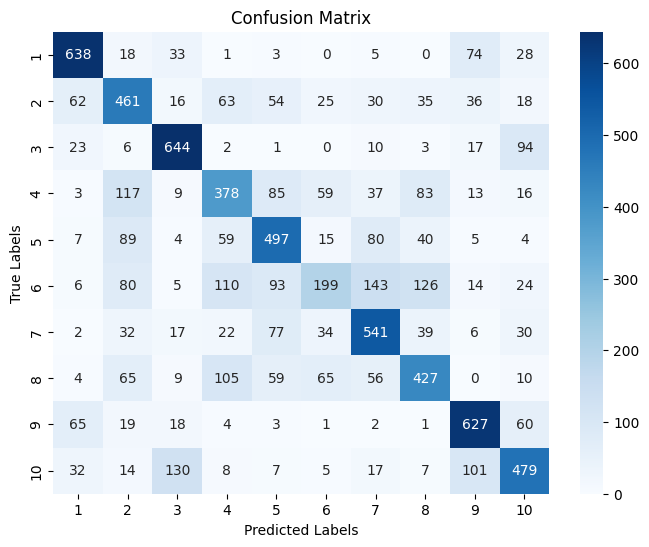

In [43]:
# CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)

indices = list(range(len(class_names)))
second_item = indices.pop(1)  
indices.append(second_item)  
new_order = indices
cm_swapped = cm[np.ix_(new_order, new_order)]
class_names_swapped = [class_names[i] for i in new_order]

plt.figure(figsize=(8,6))
sns.heatmap(cm_swapped, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names_swapped, yticklabels=class_names_swapped)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('task1_confusion_mtx.png')
plt.show()


In [44]:
# CLASSIFICATION REPORT
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.80      0.78       800
          10       0.63      0.60      0.61       800
           2       0.51      0.58      0.54       800
           3       0.73      0.81      0.76       800
           4       0.50      0.47      0.49       800
           5       0.57      0.62      0.59       800
           6       0.49      0.25      0.33       800
           7       0.59      0.68      0.63       800
           8       0.56      0.53      0.55       800
           9       0.70      0.78      0.74       800

    accuracy                           0.61      8000
   macro avg       0.60      0.61      0.60      8000
weighted avg       0.60      0.61      0.60      8000



# 10. Accuracy and Loss Curves


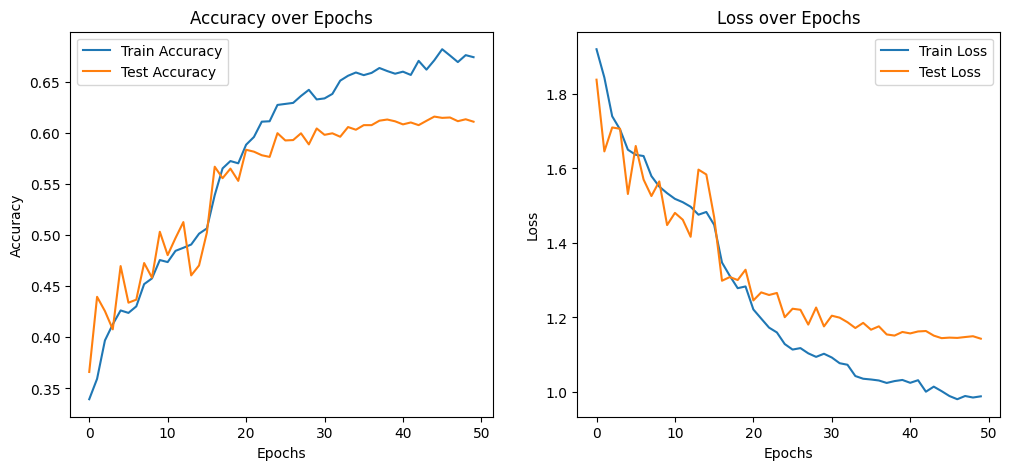

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('task1_accuracy_plot.png')